# Face Recognition Model 1

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools

# Importing Deep Learning Libraries

import keras
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential, load_model
from keras.optimizers import Adam,SGD,RMSprop
from kerastuner.tuners import Hyperband
from kerastuner.engine.hypermodel import HyperModel
from kerastuner.engine.hyperparameters import HyperParameters
from keras.callbacks import ModelCheckpoint


C:\Users\makpe\AppData\Local\Temp\ipykernel_2948\610799811.py:16: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband


In [4]:
import os
current_directory = os.getcwd()
print("Current Directory:", current_directory)


Current Directory: c:\Users\makpe\OneDrive\Documents\Data Scientist\Deep Learning\Final_Project_DL_Oct_23


# EDA

Angry
Fear
Happy
Neutral
Sad
Suprise


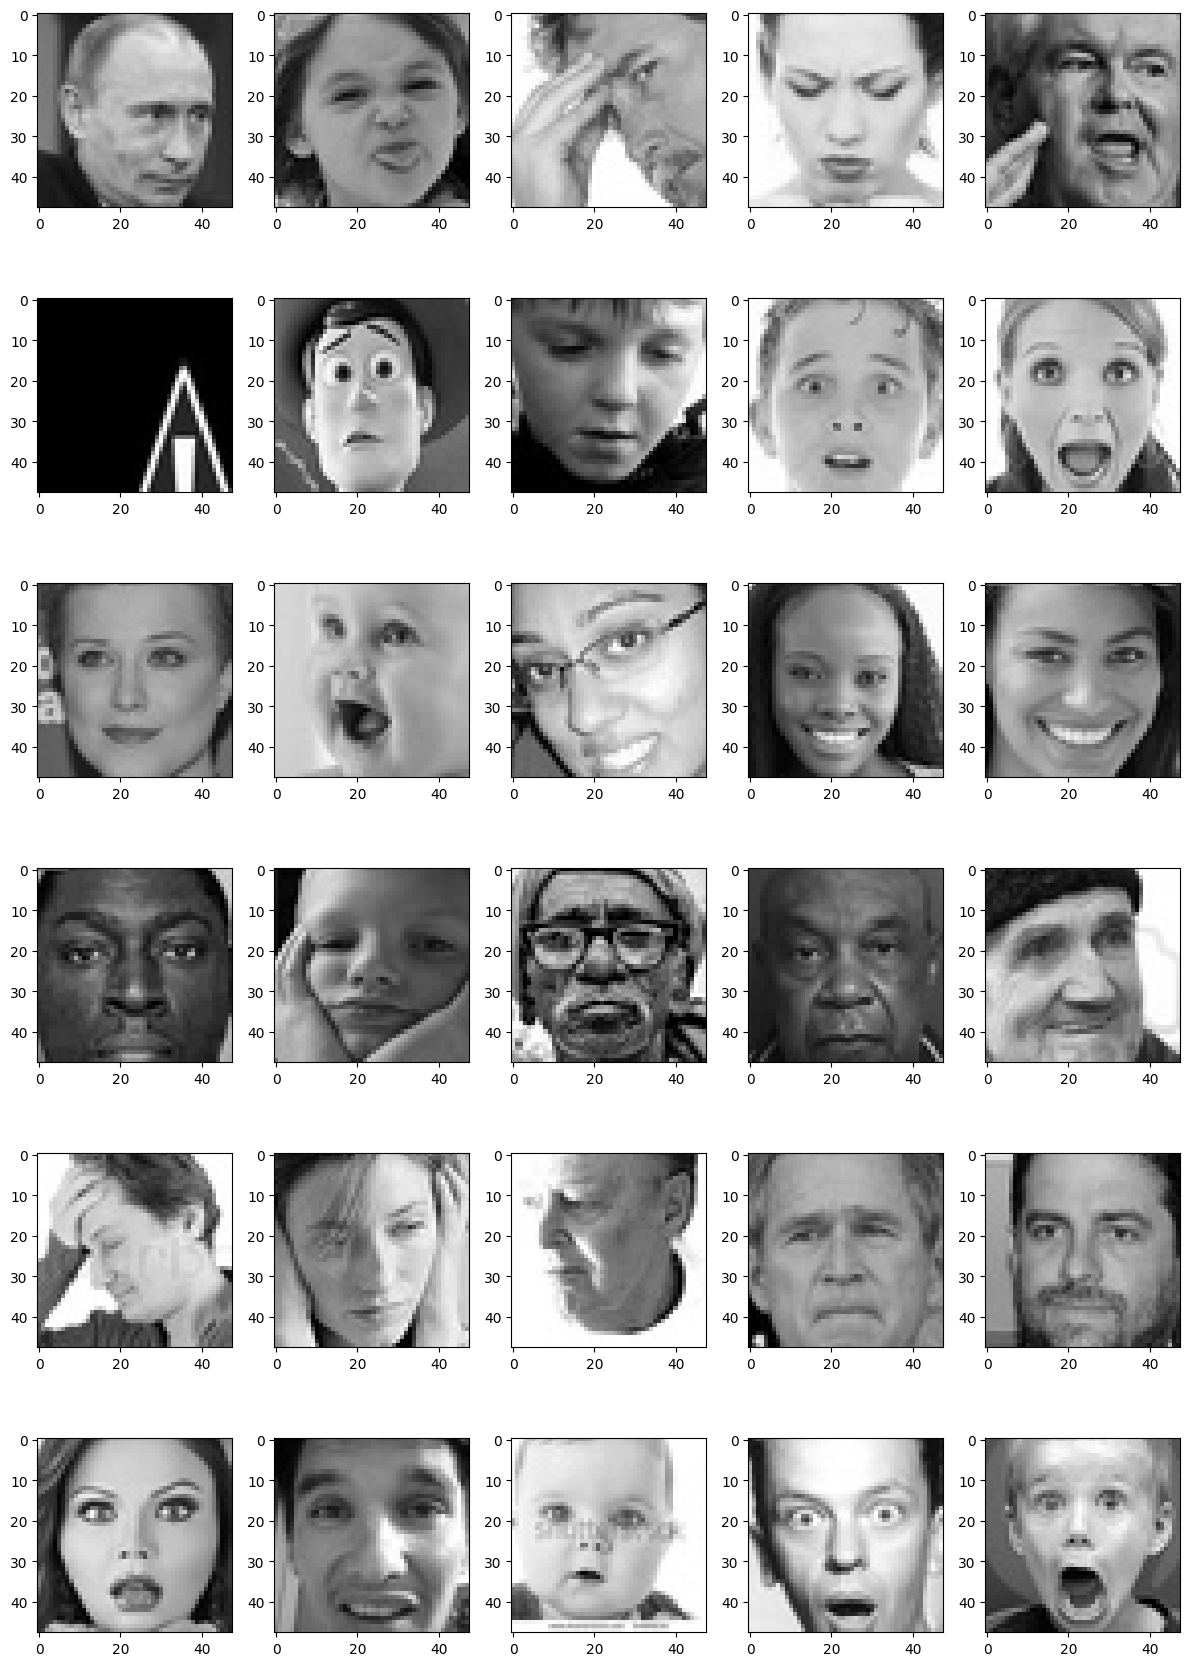

In [6]:
pic_size = 48

folder_path = current_directory + "/face_recognition_dataset/"

plt.figure(0, figsize=(12,20))
cpt = 0

for expression in os.listdir(folder_path + "Training/Training/"):
    print(expression)
    for i in range(1,6):
        cpt += 1
        plt.subplot(7,5,cpt)
        img = load_img(folder_path+'Training/Training/'+expression+"/"+os.listdir(folder_path+"Training/Training/"+expression)[i],target_size=(pic_size,pic_size))
        plt.imshow(img,cmap="gray")
        pass
    pass

plt.tight_layout()
plt.show()



In [47]:
class_names = []

for expression in os.listdir(folder_path+"Training/Training/"):
    class_names.append(expression)
    print(str(len(os.listdir(folder_path+"Training/Training/"+expression)))+" "+expression+" images")
    pass

3995 Angry images
4097 Fear images
7215 Happy images
4965 Neutral images
4830 Sad images
3171 Suprise images


In [9]:
class_names

['Angry', 'Fear', 'Happy', 'Neutral', 'Sad', 'Suprise']

## Making Training and Validation Data

In [10]:
def load_class(class_names, index, num_examples, mode):
    images = []
    class_name = class_names[index]
    
    TRAIN_PATH = folder_path + "Training/Training/" + class_name
    TEST_PATH = folder_path + "Testing/Testing/" + class_name
    PATH = ''
    if mode == 0:
        PATH = TRAIN_PATH
    else:
        PATH = TEST_PATH
    
    img_names = os.listdir(PATH)
    img_names = np.random.RandomState(seed=69).permutation(img_names)
    
    for i in range(num_examples):
        img = io.imread(PATH + "/" + img_names[i])
        img = img.reshape([48, 48, 1])
        images.append(img)

    labels = np.empty(num_examples)
    labels.fill(index)
    
    return np.array(images), keras.utils.to_categorical(labels, len(class_names), dtype=int)

In [35]:
from skimage import io

data_train = []
label_train = []
for i in range(len(class_names)):
    data_part, label_part = load_class(class_names, i, 420, 0)
    data_train.extend(data_part)
    label_train.extend(label_part)
    
X_train = np.array(data_train)
y_train = np.array(label_train)

In [36]:
X_train.shape

(2520, 48, 48, 1)

In [37]:
y_train.shape

(2520, 6)

In [38]:
data_test = []
label_test = []
for i in range(len(class_names)):
    data_part, label_part = load_class(class_names, i, 110, 1)
    data_test.extend(data_part)
    label_test.extend(label_part)
    
X_test = np.array(data_test)
y_test = np.array(label_test)

In [39]:
X_test.shape

(660, 48, 48, 1)

In [40]:
y_test.shape

(660, 6)

## Image Pre-processing

In [41]:
batch_size = 128

datagen_train = ImageDataGenerator(rescale= 1/255., 
                             horizontal_flip= True, 
                             rotation_range=30, 
                             width_shift_range=0.1, 
                             height_shift_range=0.1, 
                             shear_range=0.2,
                             zoom_range=0.2, 
                             fill_mode='nearest')

datagen_test = ImageDataGenerator(rescale= 1/255.)

train_generator = datagen_train.flow(X_train, y_train, batch_size = 64, shuffle = True, seed = 69)

val_generator = datagen_test.flow(X_test, y_test, batch_size = 64, shuffle = True, seed = 69)


## Build Model function

In [43]:
def build_model(hp):
    model = Sequential()

    no_of_classes = 6

    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48, 48, 1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Conv2D(128, (5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout_3', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout_4', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Flatten())

    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(hp.Float('dropout_5', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(hp.Float('dropout_6', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Dense(no_of_classes, activation='softmax'))

    # Configure the optimizer and learning rate
    lr_method = hp.Choice('learning_rate_method', ['adam', 'rmsprop'])
    
    if lr_method == 'adam':
        opt = Adam(learning_rate=hp.Float('adam_learning_rate', min_value=1e-5, max_value=1e-2, sampling='log'))
    elif lr_method == 'rmsprop':
        opt = RMSprop(learning_rate=hp.Float('rmsprop_learning_rate', min_value=1e-5, max_value=1e-2, sampling='log'))
    else:
        raise ValueError("Invalid learning_rate_method")

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model



## Checkpoints on the Model

In [45]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./model2.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0.00005,     
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [checkpoint, early_stopping, reduce_learningrate]

## Keras Tuner Optimization

In [23]:
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20, # Number of different hyperparameter combinations to try
    factor=3,  
    directory='my_hyperband_directory',  # Directory to store results
    project_name='emotion_classification'  # Name of the tuning project
)

INFO:tensorflow:Reloading Tuner from my_hyperband_directory\emotion_classification\tuner0.json


In [31]:
# Search for the best hyperparameters
tuner.search(train_generator, epochs=20, validation_data=val_generator, callbacks=callbacks_list)  # Replace with your data

INFO:tensorflow:Oracle triggered exit


In [32]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

In [33]:
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_6 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 128)      

## Fitting the Model

In [ ]:
history = best_model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=callbacks_list
)

In [44]:
best_model = load_model(current_directory + '/model2.h5')  